In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('NS_Data\combined_trein_data_modified.csv')

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_36292\1326722430.py:3: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('NS_Data\combined_trein_data_modified.csv')


In [8]:
df.dtypes

Service:RDT-ID                    int64
Service:Date                     object
Service:Type                     object
Service:Company                  object
Service:Train number              int64
Service:Completely cancelled       bool
Service:Partly cancelled           bool
Service:Maximum delay             int64
Stop:RDT-ID                       int64
Stop:Station code                object
Stop:Station name                object
Stop:Arrival time                object
Stop:Arrival delay              float64
Stop:Arrival cancelled             bool
Stop:Departure time              object
Stop:Departure delay            float64
Stop:Departure cancelled           bool
Stop:Platform change               bool
Stop:Planned platform            object
Stop:Actual platform             object
dtype: object

In [9]:
df_features = df[['Service:RDT-ID',
        'Service:Type',
        'Service:Company',
        'Service:Completely cancelled',
        'Service:Partly cancelled',
        'Stop:Station name',
        'Stop:Departure time',
        'Stop:Departure delay',
        'Stop:Platform change'
        ]]

df_arrivals = df[['Service:RDT-ID',
                  'Stop:Station name',
                  'Stop:Arrival time',
                  'Stop:Arrival delay'
                  ]]

df.dtypes

Service:RDT-ID                    int64
Service:Date                     object
Service:Type                     object
Service:Company                  object
Service:Train number              int64
Service:Completely cancelled       bool
Service:Partly cancelled           bool
Service:Maximum delay             int64
Stop:RDT-ID                       int64
Stop:Station code                object
Stop:Station name                object
Stop:Arrival time                object
Stop:Arrival delay              float64
Stop:Arrival cancelled             bool
Stop:Departure time              object
Stop:Departure delay            float64
Stop:Departure cancelled           bool
Stop:Platform change               bool
Stop:Planned platform            object
Stop:Actual platform             object
dtype: object

### Feature engineering
In this file I will be taking a deep look into the changes I will be making to some of the features, for example changing the date-time to different columns showing which month, which day and if it is a holiday. These temporal features are needed because I will be training a time based model. I will also be deciding what exactly I will be predicting.

#### Temporal features
The temporal features in my dataset are the timestamps, right now this is set in a single column, this column has a string in the format yyyy-mm-dd and yyyy-mm-dd-hh-mm-ss, when training a model seperating these values is vital since the model will then learn from different features and make it so it will find correlations between these values, which is not possible when having these values in a single big string.
<br><br>
First I need to change the columns I plan on using to date time, I can then use pandas functions to generate seperate columns for days, hours, years etc. For now I will be looking at departure time.

In [ ]:
import numpy as np

df_features['departure datetime'] = pd.to_datetime(df_features['Stop:Departure time'], errors='coerce', utc=True)
df_features['departure year'] = df_features['departure datetime'].dt.year
df_features['departure month'] = df_features['departure datetime'].dt.month
df_features['departure day'] = df_features['departure datetime'].dt.day
df_features['departure hour'] = df_features['departure datetime'].dt.hour
df_features['departure minute'] = df_features['departure datetime'].dt.minute
df_features['departure weekday'] = df_features['departure datetime'].dt.weekday

conditions = [
    df_features['departure month'].isin([12, 1, 2]),
    df_features['departure month'].isin([3, 4, 5]),
    df_features['departure month'].isin([6, 7, 8]),
    df_features['departure month'].isin([9, 10, 11])
]
choices = [4, 1, 2, 3]
df_features['season'] = np.select(conditions, choices)

df_features = df_features.drop(["Stop:Departure time", "departure datetime"], axis=1)

df_features.head()

C:\Users\bramm\AppData\Local\Temp\ipykernel_36292\2578982011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['departure datetime'] = pd.to_datetime(df_features['Stop:Departure time'], errors='coerce', utc=True)
C:\Users\bramm\AppData\Local\Temp\ipykernel_36292\2578982011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['departure year'] = df_features['departure datetime'].dt.year
C:\Users\bramm\AppData\Local\Temp\ipykernel_36292\2578982011.py:6: SettingWithCopyWarning: 
A valu

,Service:RDT-ID,Service:Type,Service:Company,Service:Completely cancelled,Service:Partly cancelled,Stop:Station name,Stop:Departure delay,Stop:Platform change,departure year,departure month,departure day,departure hour,departure minute,departure weekday,season
0,738804,Intercity,NS,False,False,Rotterdam Centraal,1.0,True,2019.0,1.0,1.0,1.0,0.0,1.0,4
1,738804,Intercity,NS,False,False,Delft,0.0,False,2019.0,1.0,1.0,1.0,12.0,1.0,4
2,738804,Intercity,NS,False,False,Den Haag HS,1.0,False,2019.0,1.0,1.0,1.0,21.0,1.0,4
3,738804,Intercity,NS,False,False,Leiden Centraal,0.0,False,2019.0,1.0,1.0,1.0,45.0,1.0,4
4,738804,Intercity,NS,False,False,Schiphol Airport,0.0,False,2019.0,1.0,1.0,2.0,2.0,1.0,4


### Correlations
Getting the correlations between values can be essential for figuring out which features are used in the final model. For this I need to do some processing just for calculating the correlations.

In [13]:
df_correlations = df_features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encode 'Service:Type'
df_correlations['type_encoded'] = le.fit_transform(df_correlations['Service:Type'])
df_correlations = df_correlations.drop(["Service:Type"], axis=1)

# Encode 'Service:Company'
df_correlations['company_encoded'] = le.fit_transform(df_correlations['Service:Company'])
df_correlations = df_correlations.drop(["Service:Company"], axis=1)

# Encode 'Stop:Station name'
df_correlations['station_encoded'] = le.fit_transform(df_correlations['Stop:Station name'])
df_correlations = df_correlations.drop(["Stop:Station name"], axis=1)

df_correlations.head()


,Service:RDT-ID,Service:Completely cancelled,Service:Partly cancelled,Stop:Departure delay,Stop:Platform change,departure year,departure month,departure day,departure hour,departure minute,departure weekday,season,type_encoded,company_encoded,station_encoded
0,738804,False,False,1.0,True,2019.0,1.0,1.0,1.0,0.0,1.0,4,8,8,291
1,738804,False,False,0.0,False,2019.0,1.0,1.0,1.0,12.0,1.0,4,8,8,89
2,738804,False,False,1.0,False,2019.0,1.0,1.0,1.0,21.0,1.0,4,8,8,95
3,738804,False,False,0.0,False,2019.0,1.0,1.0,1.0,45.0,1.0,4,8,8,229
4,738804,False,False,0.0,False,2019.0,1.0,1.0,2.0,2.0,1.0,4,8,8,307


### Issues
my [first iteration](output.png) of the correlation matrix looked weird and incorrect, this was due to columns that are False or True not correctly being used in the calculation. I had to first change these back to integers, 1s and 0s. [old code](old_corr_code.png). I also had do delete all columns that had only 1 value in them, this sucks because i am using the first X amount of the dataset so the values will mainly be from the same time period. To fix this I had to pick random values from my dataset instead of the first X amount. HOWEVER, to get this working I had grab a seperate random data sample from the dataset.


In [ ]:
import random

amount_per_chunk = 50000

df = pd.DataFrame()

for chunk in pd.read_csv('NS_Data\combined_trein_data_modified.csv', chunksize=100_000):
    nums = random.sample(range(0, len(chunk)), amount_per_chunk)
    df = pd.concat([df, chunk.iloc[nums]])

len(df)

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_36292\123022237.py:7: SyntaxWarning: invalid escape sequence '\c'
  for chunk in pd.read_csv('NS_Data\combined_trein_data_modified.csv', chunksize=100_000):


250000

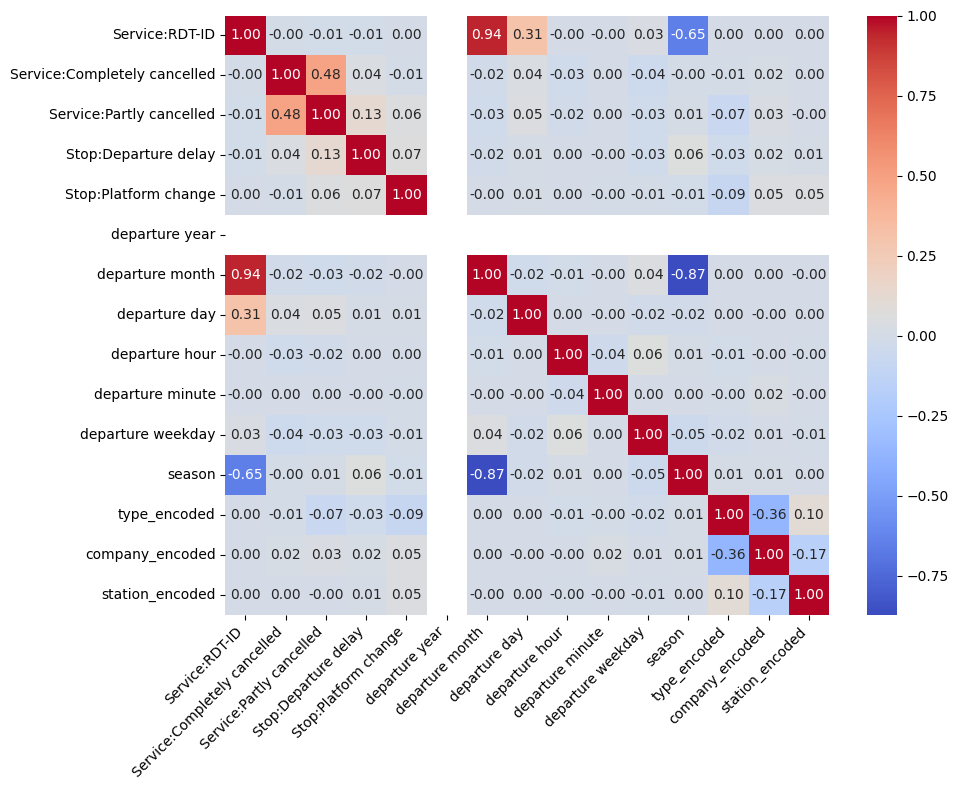

In [15]:
corr = df_correlations.corr()

bool_cols = df_correlations.select_dtypes(include=['bool']).columns
df_correlations[bool_cols] = df_correlations[bool_cols].astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm')

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
df_features.dtypes

Service:RDT-ID                    int64
Service:Type                     object
Service:Company                  object
Service:Completely cancelled       bool
Service:Partly cancelled           bool
Stop:Station name                object
Stop:Departure delay            float64
Stop:Platform change               bool
departure year                  float64
departure month                 float64
departure day                   float64
departure hour                  float64
departure minute                float64
departure weekday               float64
season                            int64
station_encoded                   int64
type_encoded                      int64
dtype: object

## !!!!!Obsidian clipping about which option to use

The next feature that I will be using is the type of train that is driving a route, in doing this I can make a distinguisment between different types of train and thus create more accuracy for each type. The column Service:Type gives this, but this is currently still in a categorical text value, I will need to change this to a numeric value for a model to learn from this feature.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_features[["Service:Type"]])
encoded_df_features = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Service:Type"]))
df_features = pd.concat([df_features.reset_index(drop=True), encoded_df_features], axis=1)
df_features = df_features.drop(["Service:Type"], axis=1)
df_features.head()


Train company / operator is another feature that will be important, in my data analysis I found that there are differences between the average delay of each operator, using this in my model as feature will most likely also improve accuracy.
<br> I could also use Train number to detect certain patterns in which trains are most likely to have failures or delays, for my first version I decided to skip this feature because this would add a lot of complications due to there being so many different trains that this would not be as helpful.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_features[["Service:Company"]])
encoded_df_features = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Service:Company"]))
df_features = pd.concat([df_features.reset_index(drop=True), encoded_df_features], axis=1)
df_features = df_features.drop(["Service:Company"], axis=1)
df_features.head()

The last thing I need to do is split the stations into different values, for this I decided to use Label encoding in stead of one-hot encoding because there are many different stations, 100+. This would create too many columns for a model.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_features['station_encoded'] = le.fit_transform(df_features['Stop:Station name'])
df_features = df_features.drop(["Stop:Station name"], axis=1)
df_features.head()

In [ ]:
df_features.dtypes

In [ ]:
df_features.to_csv('NS_Data\combined_trein_data_feature_engineered.csv', index=False)